### Import libraries

In [1]:
import sys
sys.path.append("../")

In [2]:
import preprocess.view_utils as view_utils

In [3]:
import os
from os import environ
import numpy as np
from random import choices
import pandas as pd
from tqdm.notebook import tqdm

In [4]:
import skimage.io as io
import openslide
from os import environ

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Load Sample

In [6]:
if environ.get('LVSC_DATA_PATH') is not None:
    PAIP2020_DATA_PATH = environ.get('PAIP2020_DATA_PATH')
else:
    print("Please set the environment variable PAIP2020_DATA_PATH. Read the README!")

In [7]:
train_info = pd.read_csv("../utils/data/train.csv")
train_info.head()

,case,wsi,annotation,annotation_tif,MSI-H
0,training_data_41,Train/WSI/training_data_41.svs,Train/annotation/training_data_41.xml,Train/mask_img_l2/training_data_41_l2_annotati...,0
1,training_data_38,Train/WSI/training_data_38.svs,Train/annotation/training_data_38.xml,Train/mask_img_l2/training_data_38_l2_annotati...,0
2,training_data_36,Train/WSI/training_data_36.svs,Train/annotation/training_data_36.xml,Train/mask_img_l2/training_data_36_l2_annotati...,0
3,training_data_10,Train/WSI/training_data_10.svs,Train/annotation/training_data_10.xml,Train/mask_img_l2/training_data_10_l2_annotati...,0
4,training_data_08,Train/WSI/training_data_08.svs,Train/annotation/training_data_08.xml,Train/mask_img_l2/training_data_08_l2_annotati...,0


##### Load Mask

In [8]:
mask_example = PAIP2020_DATA_PATH + train_info.iloc[0]["annotation_tif"]
mask = view_utils.mask_loader(mask_example, verbose=True)

mask shape: (5816, 7594)


#### Load Whole Image Slide

In [9]:
DISPLAY_LEVEL=2
svs_example = PAIP2020_DATA_PATH + train_info.iloc[0]["wsi"]

In [10]:
wsi_head = openslide.OpenSlide(svs_example)
print("Level dimensions: {}".format(wsi_head.level_dimensions))

Level dimensions: ((121512, 93068), (30378, 23267), (7594, 5816), (3797, 2908))


In [11]:
new_size = (wsi_head.level_dimensions[DISPLAY_LEVEL][1], wsi_head.level_dimensions[DISPLAY_LEVEL][0])
print("New Size Level {}: {}".format(DISPLAY_LEVEL, new_size))

New Size Level 2: (5816, 7594)


In [12]:
slide_img = wsi_head.read_region((0, 0), DISPLAY_LEVEL, wsi_head.level_dimensions[DISPLAY_LEVEL])

In [13]:
full_slide_img = np.asarray(slide_img)[...,:3]
print("Full Slide Shape: {}".format(full_slide_img.shape))
print("Slide Info -> Max: {} / Min: {}".format(full_slide_img.max(), full_slide_img.min()))

Full Slide Shape: (5816, 7594, 3)
Slide Info -> Max: 255 / Min: 9


## Padding

In [14]:
import cv2

In [15]:
full_slide_img.shape

(5816, 7594, 3)

In [16]:
max_size = max(full_slide_img.shape[:2])

In [17]:
padded_array = np.zeros((max_size, max_size, 3)).astype(full_slide_img.dtype)

In [18]:
shape = np.shape(full_slide_img)
padded_array[:shape[0], :shape[1], :shape[2]] = full_slide_img

In [19]:
width, height = 512, 512
dim = (width, height)
resized = cv2.resize(padded_array, dim)

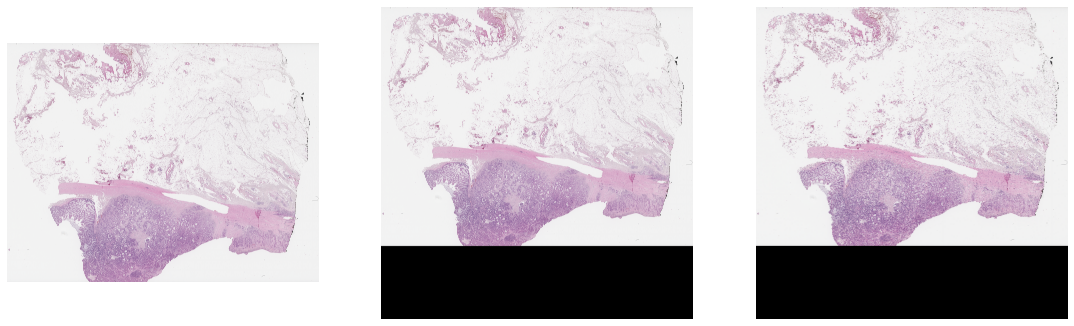

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(19, 19))
ax1.axis('off'); ax2.axis('off'); ax3.axis('off')
ax1.imshow(full_slide_img)
ax2.imshow(padded_array)
ax3.imshow(resized)

### Unpad

In [21]:
dim = (max_size, max_size)
unresized = cv2.resize(resized, dim, interpolation = cv2.INTER_AREA)

In [22]:
unpadded_array = np.zeros((full_slide_img.shape[0], full_slide_img.shape[1], 3)).astype(full_slide_img.dtype)

In [23]:
unpadded_array = unresized[:shape[0], :shape[1], :shape[2]]

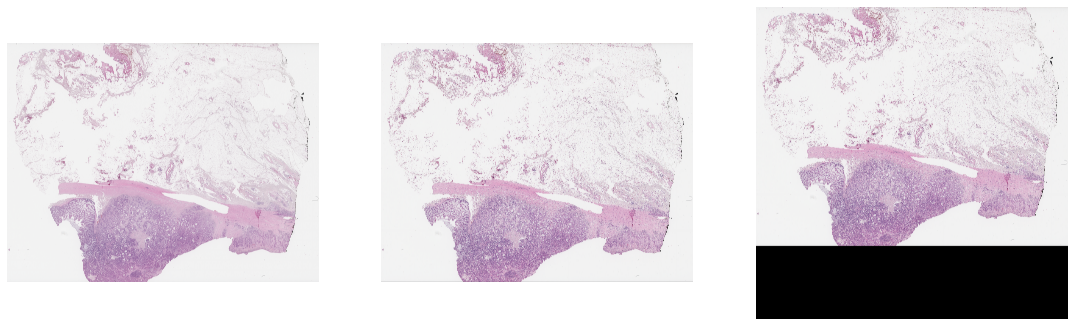

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(19, 19))
ax1.axis('off'); ax2.axis('off'); ax3.axis('off')
ax1.imshow(full_slide_img)
ax2.imshow(unpadded_array)
ax3.imshow(unresized)

### Utils function

In [25]:
from utils.training import reescale_img

In [26]:
full_slide_img.shape

(5816, 7594, 3)

In [27]:
dim = 512, 512
tiny = reescale_img(full_slide_img, dim)
print(tiny.shape)

(512, 512, 3)


In [29]:
original = reescale_img(tiny, full_slide_img.shape[0:2])
print(original.shape)

(5816, 7594, 3)


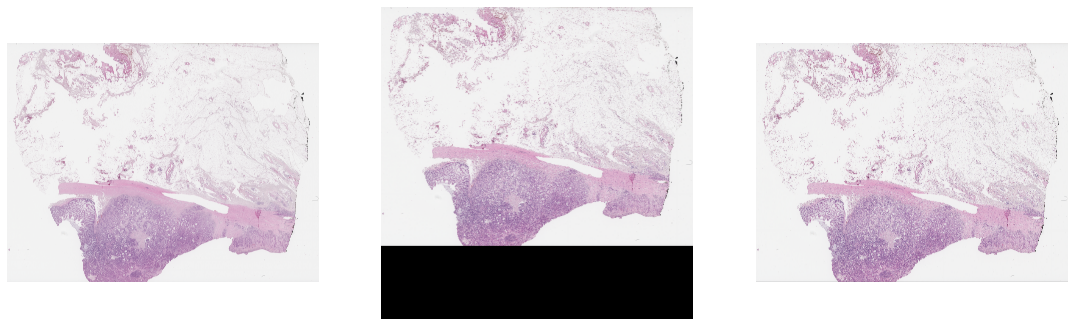

In [30]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(19, 19))
ax1.axis('off'); ax2.axis('off'); ax3.axis('off')
ax1.imshow(full_slide_img)
ax2.imshow(tiny)
ax3.imshow(original)

### Loading generated

In [62]:
rootdir = PAIP2020_DATA_PATH + "Train/resized_level2_size512"
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if ".jpg" in file :
            relative_path = os.path.join("Train/resized_level2_size512/", file)
            absolute_path = os.path.join(rootdir, file)
            break

In [60]:
image = (io.imread(absolute_path)).astype(np.uint8)
mask = (io.imread(absolute_path[:-3]+"png")).astype(np.float32)

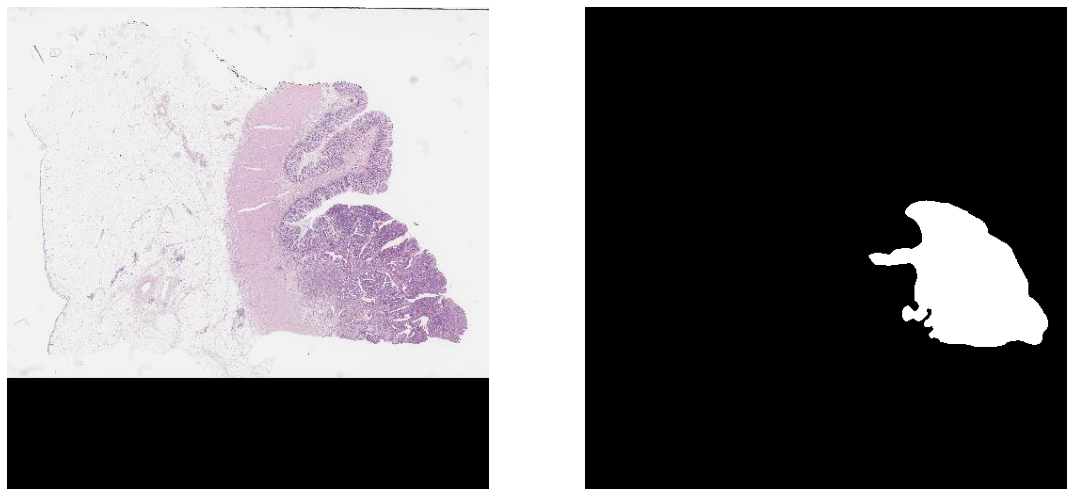

In [61]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(19, 19))
ax1.axis('off'); ax2.axis('off')
ax1.imshow(image)
ax2.imshow(mask, cmap="gray")

# Predictions

In [14]:
from utils.metrics import * 

### Validation dataset

In [15]:
from utils.data_augmentation import data_augmentation_selector
from utils.dataload import LowResolutionDataset
from torch.utils.data import DataLoader

In [16]:
slide_level = 2
low_res = 512
normalize = False
seed = 2020

In [17]:
data_augmentation, img_size, crop_size = "none", 512, 512
train_aug, train_aug_img, val_aug = data_augmentation_selector(data_augmentation, img_size, crop_size)

Using None Data Augmentation


In [18]:
val_dataset = LowResolutionDataset(
    "validation", slide_level, low_res, val_aug, [], normalize=normalize
)

In [19]:
batch_size = 1
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=False)

#### Load model

In [17]:
from models import *

In [18]:
model_name = "resnet34_unet_imagenet_encoder"
model = model_selector(model_name, in_size=(crop_size, crop_size))
model = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))


--- Frosted pretrained backbone! ---


In [19]:
model_checkpoint = "../results/lvl2_lowres512/resnet34_unet_imagenet_encoder/adam/bce_dice/weights0.1,0.85,0.05_danone_minlr0.0001_maxlr0.01/model_resnet34_unet_imagenet_encoder_best_iou.pt"
model.load_state_dict(torch.load(model_checkpoint))

<All keys matched successfully>

In [20]:
model.eval()

DataParallel(
  (module): ResUnetv4(
    (resnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): Batc

In [21]:
val_loader.dataset.df_images.head()

,case,image,mask,MSI-H
0,training_data_16,Train/resized_level2_size512/training_data_16.jpg,Train/resized_level2_size512/training_data_16.png,0
1,training_data_13,Train/resized_level2_size512/training_data_13.jpg,Train/resized_level2_size512/training_data_13.png,0
2,training_data_01,Train/resized_level2_size512/training_data_01.jpg,Train/resized_level2_size512/training_data_01.png,1
3,training_data_14,Train/resized_level2_size512/training_data_14.jpg,Train/resized_level2_size512/training_data_14.png,0
4,training_data_19,Train/resized_level2_size512/training_data_19.jpg,Train/resized_level2_size512/training_data_19.png,0


In [45]:
val_loader.dataset.df_images.iloc[0]["case"]

In [46]:
ious

[0.789701996364692,
 0.7777468001520724,
 0.8129824292181389,
 0.7632884479092858,
 0.5625540405720015,
 0.7753351206434328,
 0.6539314204720978]